# CartPole

In this notebook we implement all the parts needed to solve CartPole using DQN. This notebook is split into parts based on what part of the problem they solve.

In [1]:
%matplotlib inline

In [2]:
import torch
import gym
import time
import matplotlib.pyplot as plt

# Using GPU if possible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Data

First, we should look at the data we will be dealing with. At each timestep, the CartPole environment gives us current state of the game. Let's examine it.

In [3]:
env = gym.make('CartPole-v0')
env.reset()
for _ in range(1000):
    env.render()
    observation, reward, done, _ = env.step(env.action_space.sample()) # take a random action
    print(observation)
    if done:
        break
env.close()

[ 0.04532307 -0.20368747 -0.04777746  0.28443043]
[ 0.04124932 -0.00791781 -0.04208885 -0.0229302 ]
[ 0.04109097  0.18778168 -0.04254745 -0.32858992]
[ 0.0448466  -0.00670955 -0.04911925 -0.04962228]
[ 0.04471241  0.18908105 -0.0501117  -0.35738923]
[ 0.04849403  0.38487829 -0.05725948 -0.66544307]
[ 0.05619159  0.19059756 -0.07056834 -0.39132467]
[ 0.06000355  0.38664636 -0.07839484 -0.70539582]
[ 0.06773647  0.58276198 -0.09250275 -1.02169024]
[ 0.07939171  0.388986   -0.11293656 -0.759426  ]
[ 0.08717143  0.19558631 -0.12812508 -0.50430737]
[ 0.09108316  0.39225907 -0.13821123 -0.83446417]
[ 0.09892834  0.19926856 -0.15490051 -0.5882438 ]
[ 0.10291371  0.0066162  -0.16666539 -0.34808407]
[ 0.10304604  0.20366794 -0.17362707 -0.68833909]
[ 0.10711939  0.40072004 -0.18739385 -1.03026339]
[ 0.11513379  0.59777366 -0.20799912 -1.37544103]
[ 0.12708927  0.40576739 -0.23550794 -1.15435112]


We can see a problem there - observations are sets of environmnent variables, rather than actual screen. We would like to change that, because as an input to a neural network, we would like raw pixel values.

(400, 600, 3)
(400, 600, 3)
(400, 600, 3)
(400, 600, 3)
(400, 600, 3)
(400, 600, 3)
(400, 600, 3)
(400, 600, 3)
(400, 600, 3)
(400, 600, 3)
(400, 600, 3)
(400, 600, 3)
(400, 600, 3)
(400, 600, 3)
(400, 600, 3)
(400, 600, 3)
(400, 600, 3)
(400, 600, 3)
(400, 600, 3)
(400, 600, 3)
(400, 600, 3)
(400, 600, 3)
(400, 600, 3)
(400, 600, 3)
(400, 600, 3)
(400, 600, 3)
(400, 600, 3)
(400, 600, 3)
(400, 600, 3)
(400, 600, 3)
(400, 600, 3)


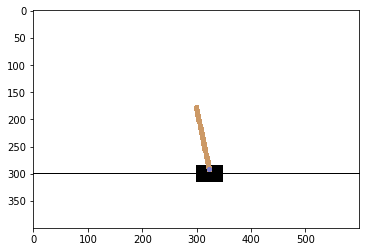

In [4]:
env = gym.make('CartPole-v0')
env.reset()
for _ in range(1000):
    screen = env.render(mode='rgb_array')
    plt.imshow(screen)
    print(screen.shape)
    observation, reward, done, _ = env.step(env.action_space.sample()) # take a random action
    if done:
        break
env.close()

Perfect. Now we can see that there is a lot of empty space in the upper half of the screen and under the cart. We also don't need the view to be so wide, so we are going to make some adjustments. The screen is 400 pixels in height and 600 pixels in width. Ideally, we would like the preprocessed frame to be square - therefore we are going to cut 150 pixels from upper half, 50 pixels from lower half, 50 pixels from both left and right and finally, we are going to apply a transform to get a 128x128 greyscale image and finaly normalize pixel values to be in range <0, 255>.

In [5]:
import numpy as np

from skimage.transform import resize
from IPython import display

In [6]:
def rgb2grayscale(array_rgb):
    consts = np.array([0.2989, 0.5870, 0.1140])
    array_grayscale = np.sum(array_rgb * consts[None, None, :], axis=-1)
    return array_grayscale

In [7]:
def preprocess(frame):
    frame = frame[150:350, 50:550, :]
    frame = rgb2grayscale(frame)
    frame = resize(frame, (124, 124))
    frame = frame / 255.0
    return frame

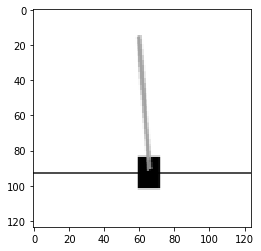

In [8]:
env = gym.make('CartPole-v0')
env.reset()
for _ in range(1000):
    screen = env.render(mode='rgb_array')
    frame = preprocess(screen)
    
    display.clear_output(wait=True)
    plt.imshow(frame, cmap="gray")
    plt.pause(0.001)
    
    observation, reward, done, _ = env.step(env.action_space.sample()) # take a random action
    if done:
        break
env.close()

This looks like a sufficient input for DQN.

### Model

First, we implement the network itself. We can see that this network has slightly different structure, than the one in the paper. This is due to the different input dimensionality (also the number of channels in last convolutional layer had to be lowered to decrease the size of subsequent dense layer).

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [10]:
class DQN(nn.Module):
    def __init__(self, action_count):
        super().__init__()
        self.conv_1 = nn.Conv2d(4, 16, 8, stride=4)
        self.conv_2 = nn.Conv2d(16, 32, 4, stride=2)
        self.conv_3 = nn.Conv2d(32, 32, 3, stride=1)

        self.dense_first = nn.Linear(4_608, 512)
        self.dense_second = nn.Linear(512, action_count)

    def forward(self, inp):
        # inp = batch x channels x width x height
        x = F.relu(self.conv_1(inp))
        x = F.relu(self.conv_2(x))
        x = F.relu(self.conv_3(x))

        x = x.view(x.shape[0], x.shape[1] * x.shape[2] * x.shape[3])
        x = F.relu(self.dense_first(x))
        return self.dense_second(x)

Here we notice that we actually have two networks - this improves the stability of learning and prevents divergence during learning.

In [11]:
dqn_current = DQN(2).to(device)
dqn_new = DQN(2).to(device)
dqn_new.load_state_dict(dqn_current.state_dict())
dqn_new.eval()

DQN(
  (conv_1): Conv2d(4, 16, kernel_size=(8, 8), stride=(4, 4))
  (conv_2): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2))
  (conv_3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (dense_first): Linear(in_features=4608, out_features=512, bias=True)
  (dense_second): Linear(in_features=512, out_features=2, bias=True)
)

### Memory

Learning from recent experiences might have negative effects on the policy of model. Therefore we implement a replay memory, from which we sample experiences to be used during training. Each experience in memory is represented as a tuple (state, action, reward, new state). After filling up the memory, we start again from the beginning of memory, rewriting previous experiences. 

The bigger the memory the better - however, we have to also take into consideration the operation memory (RAM) requirements. 

In [12]:
class Memory:
    def __init__(self, max_size):
        self.states = np.zeros((max_size, 4, 124, 124), dtype=np.uint8)
        self.actions = np.zeros((max_size), dtype=np.uint8)
        self.rewards = np.zeros((max_size), dtype=np.uint8)
        self.new_states = np.zeros((max_size, 4, 124, 124), dtype=np.uint8)
        
        self.current_idx = 0
        self.size = 0
        self.max_size = max_size
        
    def add(self, state, action, reward, new_state):
        if new_state is None:
            return
        
        self.states[self.current_idx] = state
        self.actions[self.current_idx] = action
        self.rewards[self.current_idx] = reward
        self.new_states[self.current_idx] = new_state
        
        if self.size < self.max_size:
            self.size += 1
            
        self.current_idx = (self.current_idx + 1) % self.max_size
    
    def sample(self, batch_size):
        batch_indices = np.random.choice(range(self.size), batch_size, False)
        return self.states[batch_indices], self.actions[batch_indices], self.rewards[batch_indices], self.new_states[batch_indices]

In [13]:
replay_size = 100_000
memory = Memory(replay_size)

### Learning, evaluation

This is the most important part - here, the DQN will learn how to play CartPole. We start by declaring several useful variables and functions. After training, we evaluate performance of the trained model.

In [14]:
import random
import torch.optim as optim

from itertools import count

In [15]:
durations = []
means = []
evaluation_results = {}

In [16]:
def plot_running_average():
    if len(durations) < 100:
        return
    display.clear_output(wait=True)
    mean = sum(durations[len(durations)-100:len(durations)]) / 100.0
    means.append(mean)
    plt.plot(range(100, len(durations)+1), means)
    plt.pause(0.001)

In [17]:
def choose_action(state, epsilon):
    if random.random() < epsilon:
        action = env.action_space.sample()
    else:
        with torch.no_grad():
            inp_torch = torch.from_numpy(state[None, :]).float().to(device)
            action_torch = dqn_current(inp_torch).argmax(axis=1)[0]
            action = action_torch.cpu().detach().numpy()

    return action

In [18]:
def evaluate():
    durations = []
    epochs = 100
    eps = 0.0

    for epoch in range(epochs):
        env.reset()
        state = np.zeros(shape=(4, 124, 124), dtype=float)

        for t in count():
            screen = env.render(mode='rgb_array')
            frame = preprocess(screen)
            state = np.concatenate((state[1:], frame[None, :]))

            action = choose_action(state, eps)
            _, _, done, _ = env.step(action)

            if done:
                durations.append(t+1)
                break

    durations = np.array(durations)
    return durations.mean()

Now we also need some hyperparameters to regulate the learning.

In [19]:
# eps - probability of selecting random action
# Epsilon is linearly annealed from eps_beg to eps_end in eps_end_frame steps
eps_beg = 1.0
eps_end = 0.01
eps_end_frame = 10_000
eps_step = (eps_beg - eps_end) / eps_end_frame

# replay_start_size - #frames saved to memory before learning starts
# scaling_factor - see paper
# update_frequency - #epochs before updating current network
epochs = 1500
eps = eps_beg
replay_start_size = 500
batch_size = 32
scaling_factor = 0.99
update_frequency = 10
optimizer = optim.RMSprop(dqn_new.parameters(), lr = 2.5e-5, momentum=0.95, eps = 0.01)

# How often, when and where are trained models saved and evaluated
save_start = 500
save_frequency = 50
models_directory = "models/"

Below is the actual training cycle. Running average of number of frames before dropping pole (per last 100 frames) is ploted after each epoch (starting after 100 epochs). 

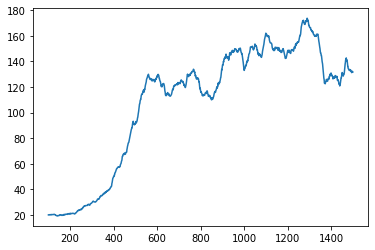

Training finished after 182.6295776327451 minutes


In [20]:
t0 = time.time()

env = gym.make('CartPole-v0')
for epoch in range(epochs):
    env.reset()
    
    state = np.zeros(shape=(4, 124, 124), dtype=float)
    last_state = None
    last_action = None
    last_reward = None
    
    for t in count():
        screen = env.render(mode='rgb_array')
        frame = preprocess(screen)
        state = np.concatenate((state[1:], frame[None, :]))
        
        if t > 0:
            # To lower the space demands, be save states as uint8, not float
            memory.add(np.floor(last_state*255), last_action, last_reward, np.floor(state*255))
            eps = max(eps_end, eps - eps_step)
        
        action = choose_action(state, eps)
        _, reward, done, _ = env.step(action)
        
        # In this part, the update of network occurs
        if memory.size >= replay_start_size:
            states, actions, rewards, new_states = memory.sample(32)
            
            states = torch.from_numpy(states).float().to(device) / 255.0
            actions = torch.from_numpy(actions).long().to(device)
            rewards = torch.from_numpy(rewards).float().to(device)
            new_states = torch.from_numpy(new_states).float().to(device) / 255.0
            
            # Find experiences where next state was terminal (ie the game ended)
            episodes_end_mask = (new_states == 0.0).all(3).all(2).all(1)
            
            output_current = torch.max(dqn_current(new_states), 1).values
            output_new = dqn_new(states)[range(batch_size), actions]
            
            # If the game ends this frame, the Q-value for next state is zero
            output_current = torch.where(episodes_end_mask,
                                         torch.zeros(
                                             batch_size,
                                             device=device),
                                         output_current).detach()
            
            target = rewards + (scaling_factor * output_current)

            optimizer.zero_grad()
            
            loss = F.mse_loss(output_new, target)
            loss.backward()

            optimizer.step()
            
        # Adding terminal experiences into memory - distinguished by state consisting of zeros
        if done:
            # To lower the space demands, be save states as uint8, not float
            memory.add(np.floor(state*255), action, reward, np.zeros((4, 124, 124)))
            eps = max(eps_end, eps - eps_step)
            durations.append(t+1)
            break
            
        last_state = state
        last_action = action
        last_reward = reward
        
    # Update current network
    if (epoch + 1) % update_frequency == 0:
        dqn_current.load_state_dict(dqn_new.state_dict())
    
    # Save checkpoint
    if ((epoch + 1) % save_frequency == 0) and ((epoch + 1) >= save_start):
        cp_name = "cp_epoch_" + str(epoch + 1)
        torch.save(dqn_current.state_dict(),f'{models_directory}{cp_name}.pt')
        evaluation_results[epoch + 1] = evaluate()
        
    plot_running_average()
        
env.close()

t1 = time.time()
print("Training finished after", (t1 - t0) / 60.0, "minutes")

In [21]:
evaluation_results

{500: 115.24,
 550: 108.43,
 600: 108.28,
 650: 103.76,
 700: 126.14,
 750: 132.26,
 800: 108.66,
 850: 153.21,
 900: 159.86,
 950: 155.36,
 1000: 171.04,
 1050: 163.24,
 1100: 154.06,
 1150: 152.65,
 1200: 124.61,
 1250: 186.93,
 1300: 148.87,
 1350: 99.97,
 1400: 92.78,
 1450: 80.6,
 1500: 86.18}

Evaluation of trained model - mean performance of 100 games. But first, we need to load the best performing model.

In [28]:
filepath = "../models/cp_epoch_1250.pt"

dqn_current = DQN(2).to(device)
dqn_current.load_state_dict(torch.load(filepath))

<All keys matched successfully>

Mean duration: 190.96


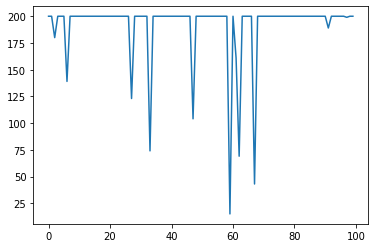

In [29]:
durations = []
means = []
epochs = 100
eps = 0.00

env = gym.make('CartPole-v0')
for epoch in range(epochs):
    env.reset()
    state = np.zeros(shape=(4, 124, 124), dtype=float)
    
    for t in count():
        screen = env.render(mode='rgb_array')
        frame = preprocess(screen)
        state = np.concatenate((state[1:], frame[None, :]))
        
        action = choose_action(state, eps)
        _, _, done, _ = env.step(action)
            
        if done:
            durations.append(t+1)
            break
            
env.close()

durations = np.array(durations)
plt.plot(durations)
print("Mean duration:", durations.mean())

### Trained model

In order to train a well performing model, we have to train for many epochs. I have already trained such a model and saved it into /models directory - it's learning can be seen in the section above. Here we will look at it's performance.

In [20]:
filepath = "models/dqn_cartpole.pt"

dqn_current = DQN(2).to(device)
dqn_current.load_state_dict(torch.load(filepath))

<All keys matched successfully>

Mean duration: 194.42


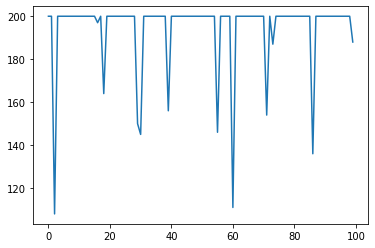

In [21]:
durations = []
means = []
epochs = 100
eps = 0.00

env = gym.make('CartPole-v0')
for epoch in range(epochs):
    env.reset()
    state = np.zeros(shape=(4, 124, 124), dtype=float)
    
    for t in count():
        screen = env.render(mode='rgb_array')
        frame = preprocess(screen)
        state = np.concatenate((state[1:], frame[None, :]))
        
        action = choose_action(state, eps)
        _, _, done, _ = env.step(action)
            
        if done:
            durations.append(t+1)
            break
            
env.close()

durations = np.array(durations)
plt.plot(durations)
print("Mean duration:", durations.mean())

Our model has achieved mean of 194 frames before pole falls per 100 runs. Unfortunately, this task is considered solved, when the model achieves a mean of 195 frames or higher, thus the network we trained does not qualify as a solution to the problem - even though it still reached a better score than random moves, which tend to be around 20 frames - we can see that for example at the beginning of training above.